# Section 2.3.3: Trial 1 BPs in data reuploading QNNs
This notebook contains the code run to generate the plots found in Section 2.3.3 of the accompaining thesis. Note these trials include 500 runs of 16 qubits circuits, and have a substantial compuational cost. The total run time for this code on a standard 2019 MacBook pro was roughly 20 hours. Choosing 50 runs will give the scaling, with a lot more error in the gradient, in about 2 hrs. Likewise dropping the trial at 16 qubits can allow the general scaling to be seen with substantially less computational cost.

In [1]:
# import required libraries for simulation
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from pennylane import X, Z, I, Y

In [2]:
# Set a seed for reproducibility
np.random.seed(42)

num_qubits = 4
dev = qml.device("default.qubit", wires=num_qubits)
gate_set = [qml.RX, qml.RY, qml.RZ]

# this function defines the HEA circuit as given by Figure 2.7 (A)
def HEA_circuit(params0,params, layers=1,random_gate_sequence=None, num_qubits=None):
    local_rng = np.random.default_rng(42)
    # Generate the same fixed random data using the local random generator
    data = local_rng.uniform(0, 2 * np.pi, size=(num_qubits,))

    for i in range(num_qubits):
        qml.RY(data[i], wires=i) # data encoding layer using simple angle encoding
    for j in range(layers):      # HEA circuit
        for i in range(num_qubits): # pauli rotation on each qubit 
            if i == 0 and j ==0:
                random_gate_sequence[f"{i}_{j}"](params0, wires=i) # the first param is defined seperatley to allow for 
            else:                                                  # the gradient to be calculated
                random_gate_sequence[f"{i}_{j}"](params[i,j], wires=i)

        for i in range(num_qubits - 1):
            qml.CZ(wires=[i, i + 1]) # Entangling through control z gates between neighbouring qubit

    operators = [Z(i) for i in [0,num_qubits-1]] # local pauli z operator on each qubit
    return qml.expval(sum(operators))

In [3]:
# this function defined the same HEA circuit with additional data reuploading
def DataReuploadHEA(params0,params, layers=1,random_gate_sequence=None, num_qubits=None):
    local_rng = np.random.default_rng(42)
    data = local_rng.uniform(0, 2 * np.pi, size=(num_qubits,))

    for j in range(layers):
        for i in range(num_qubits):
            qml.RY(data[i], wires=i) # data reuploading at each layer
        for i in range(num_qubits):
            if i == 0 and j ==0:
                random_gate_sequence[f"{i}_{j}"](params0, wires=i)
            else:
                random_gate_sequence[f"{i}_{j}"](params[i,j], wires=i)

        for i in range(num_qubits - 1):
            qml.CZ(wires=[i, i + 1])

    operators = [Z(i) for i in [0,num_qubits-1]]
    return qml.expval(sum(operators))

In [5]:
np.random.seed(42)
num_samples = 500 # sample 500 random circuits
# every second qubit at higher counts to save computatuion time
qubits = [2, 3, 4, 5, 6, 8,10,12,14,16]

variances = []
means = []

gate_sequence = {}
for num_qubits in qubits:
    grad_vals = []
    layers= 10*num_qubits
    for i in range(num_samples):
        dev = qml.device("default.qubit", wires=num_qubits)
        qcircuit = qml.QNode(HEA_circuit, dev, interface="autograd") # set up pennylane circuit

        grad = qml.grad(qcircuit, argnum=[0]) # specify taking the gradeint with respect to the first parameter

        for i in range(num_qubits):
            for j in range(layers):
                gate_sequence[f"{i}_{j}"] = np.random.choice(gate_set)

        params=np.random.uniform(0, 2 * np.pi, size=(num_qubits,layers))
        gradient = grad(params[0,0],params, layers=layers,random_gate_sequence=gate_sequence, num_qubits=num_qubits)
        grad_vals.append(gradient)
    variances.append(np.var(grad_vals))
    means.append(np.mean(grad_vals))
    print(f"Number of qubits: {num_qubits}, Mean: {np.mean(grad_vals)}, Variance: {np.var(grad_vals)}")

variances = np.array(variances)

qubits = np.array(qubits)



# fit the data to a line log2 and get the covariance matrix for error in fit
slope, cov = np.polyfit(qubits, np.log2(variances), 1, cov=True)

Number of qubits: 2, Mean: -0.004437523944590047, Variance: 0.19404043198078488
Number of qubits: 3, Mean: 0.015035205359542654, Variance: 0.08009088810550558
Number of qubits: 4, Mean: 0.007929763236605316, Variance: 0.04514507418798655
Number of qubits: 5, Mean: 0.004019458167247301, Variance: 0.02026259339445516
Number of qubits: 6, Mean: 0.0038082023532763874, Variance: 0.012037834159832877
Number of qubits: 8, Mean: -0.0030621035294154837, Variance: 0.002584876936507275
Number of qubits: 10, Mean: -0.000304440724489381, Variance: 0.0007225854394167157
Number of qubits: 12, Mean: -6.78341609140356e-05, Variance: 0.00017639783309430468
Number of qubits: 14, Mean: -6.128206755529744e-05, Variance: 4.51381212798921e-05


KeyboardInterrupt: 

In [11]:
# repeat trials with data reuploading
np.random.seed(42)
num_samples = 500
qubits = [2, 3, 4, 5, 6, 8,10,12,14,16]
RUvariances = []
RUmeans = []
for num_qubits in qubits:
    grad_vals = []
    layers= 10*num_qubits
    for i in range(num_samples):
        dev = qml.device("default.qubit", wires=num_qubits)
        qcircuit = qml.QNode(DataReuploadHEA, dev, interface="autograd")

        grad = qml.grad(qcircuit, argnum=[0])

        for i in range(num_qubits):
            for j in range(layers):
                gate_sequence[f"{i}_{j}"] = np.random.choice(gate_set)


        params=np.random.uniform(0, 2 * np.pi, size=(num_qubits,layers))
        gradient = grad(params[0,0],params, layers=layers,random_gate_sequence=gate_sequence, num_qubits=num_qubits)

        grad_vals.append(gradient)

    RUvariances.append(np.var(grad_vals))
    RUmeans.append(np.mean(grad_vals))
    print(f"Number of qubits: {num_qubits}, Mean: {np.mean(grad_vals)}, Variance: {np.var(grad_vals)}")

RUvariances = np.array(RUvariances)
qubits = np.array(qubits)


# fit the data to a line log2 and get the covariance matrix for error in fit
RUslope, RUcov = np.polyfit(qubits, np.log2(RUvariances), 1, cov=True)

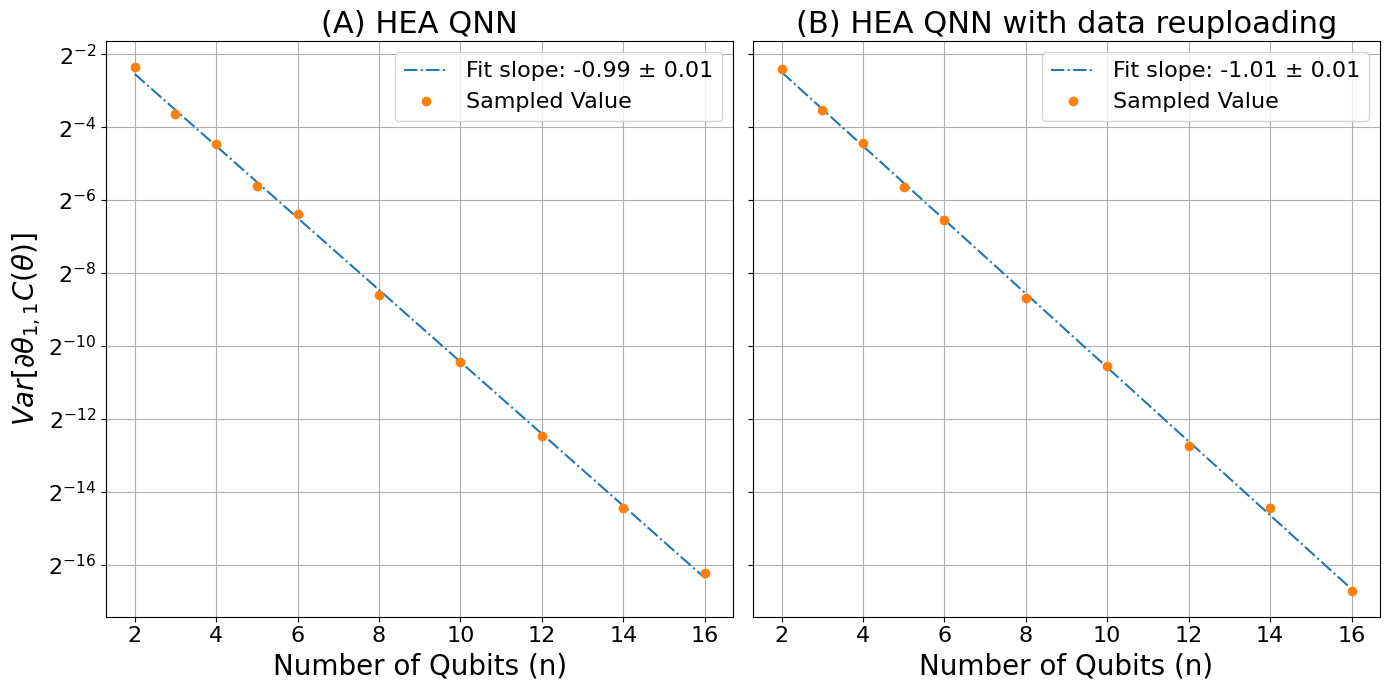

In [27]:
# visualising the data
plt.rcParams.update({'axes.labelsize': 20,  # Axis labels
                     'xtick.labelsize': 16,  # X-axis tick labels
                     'ytick.labelsize': 16,  # Y-axis tick labels
                     'legend.fontsize': 16,  # Legend font size
                     'axes.titlesize': 22})  # Titles size

fig, axs = plt.subplots(1, 2, figsize=(14, 7),sharey=True)
qubits = np.array([2, 3, 4, 5, 6, 8,10,12,14,16])
# First subplot: Reuploading HEA Circuit
axs[0].plot(qubits, 2**(slope[0] * qubits + slope[1]), "-.", label="Fit slope: {:3.2f} ± {:3.2f}".format(slope[0], np.sqrt(cov[0,0])))
axs[0].plot(qubits, variances, "o", label="Sampled Value")
axs[0].set_xlabel(r"Number of Qubits (n)")
axs[0].set_ylabel(r"$Var[\partial \theta_{1, 1} C(\theta)]$")
axs[0].set_title("(A) HEA QNN")
axs[0].legend()
axs[0].grid(True)
axs[0].set_yscale('log', base=2)

# Second subplot: Standard HEA Circuit
axs[1].plot(qubits, 2**(RUslope[0] * qubits + RUslope[1]), "-.", label="Fit slope: {:3.2f} ± {:3.2f}".format(RUslope[0], np.sqrt(RUcov[0,0])))
axs[1].plot(qubits, RUvariances, "o", label="Sampled Value")
axs[1].set_xlabel(r"Number of Qubits (n)")
axs[1].set_title("(B) HEA QNN with data reuploading")
axs[1].legend()
axs[1].grid(True)
axs[1].set_yscale('log', base=2)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()